> ## Trabalho final ECM307
> ## Rafael Rubio 20.00611-0

In [295]:
import math 
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from control import TransferFunction
import scipy.io.wavfile as wav
import sounddevice as sd
import IPython.display as ipd
from IPython.display import Audio
from sympy import I as j


REPETIÇÕES =15



# Requerimentos do trabalho:
1. Indicar as formantes encontradas para cada vogal.
2. Indicar a frequência fundamental de cada vogal.
3. Encontrar a função de Laplace para um trecho de uma determinada vogal    
4. Sintetizar a vogal no mesmo tempo da vogal original
5. Montar a segquência sintetizada A U A.


obs: não necessariamente nessa ordem

# Funções importantes do trabalho:

## Plota um grafico

In [296]:

def plotar_grafico(dado_x, dado_y, titulo, labelg="None", type="", label_x='Tempo em segundos', label_y='Amplitude', n_figure=1):
    plt.figure(n_figure)
    plt.plot(dado_x, dado_y, type, label=labelg)
    plt.title(titulo)
    plt.legend()
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return plt


## Extrai informações da vogal: 
Pontos, período da amostragem, tempo total, vetor de tempo e o valor maximo

In [297]:

def extrai_vogal(fs, Vg):
    N = len(Vg) # numero de pontos na vogal
    T1 = 1/fs # periodo de amostragem
    Ttot = (N-1)*T1 #tempo total da vogal
    Tvg= np.linspace(0, N*T1, N) # vetor tempo da vogal
    Pico = max(Vg)

    return N, T1, Tvg, Pico, Ttot



## Faz o ponderamento da vogal

In [298]:
def ponderar_vogal(N, Vg):
    Jh = np.hamming(N) # janela de hamming
    Vg_p = Vg*Jh # ponderando a vogal
    return Vg_p

## Calcula a transformada de fourier e a frequencia fundamental

In [299]:
def calcula_fourier(Vg, fs):
    Fourier = np.fft.fft(Vg) #transformada de fourier
    Fourier_cen = np.fft.fftshift(np.abs(Fourier)) #centraliza a transformada
    freq = np.linspace(-fs/2, fs/2, len(Fourier)) #vetor de frequencia
    freq_fund_vg = abs(freq[np.where(abs(Fourier_cen) == max(abs(Fourier_cen)))]) #frequencia fundamental da vogal a
    return Fourier_cen, freq, freq_fund_vg[0], Fourier


## Separa o meio da vogal

In [300]:
def corta_vogal(Vg_p, Tvg):
    meio = int(len(Vg_p)/2)
    Novo_Tvg = Tvg[meio-1000:meio+1000]
    Vg_meio = Vg_p[meio-1000:meio+1000]
    return Novo_Tvg, Vg_meio

## Acha os picos da vogal

In [301]:
def picos_vogal(Vg):
    peaks, _ = find_peaks(Vg, height=0, distance=50)
    return peaks

## Picos em um período da vogal

In [302]:
def um_periodo(picos, Vg, Tvg):
    i = int(len(picos)/2)
    y = Vg[picos[i]-10:picos[i+1]]
    periodo = Tvg[picos[i]-10:picos[i+1]]

    return periodo, y

## Picos do período da vogal fazendo derivada

In [303]:
def picos_periodo(periodo, periodo_t, vogal):

    y = np.convolve(periodo, np.ones(10)/10, mode='same')
    periodo_deriv_1_t = periodo_t[1:]
    periodo_deriv_1 = np.diff(y)

    periodo_deriv_2 = np.diff(periodo_deriv_1)
    periodo_deriv_2_t = periodo_deriv_1_t[1:]

    periodo_deriv_2 = np.where(periodo_deriv_2 > 0, 1, -1)

    zero_crossings = np.where(np.diff(np.sign(periodo_deriv_1)))[0]
    zero_crossings = zero_crossings[np.where(periodo_deriv_2[zero_crossings] < 0)]

    plt.figure(26)
    plt.plot(periodo_t, periodo)
    plt.plot(periodo_t[zero_crossings], periodo[zero_crossings], "x")
    plt.title(f"Período da vogal {vogal} com picos")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, which='both')

    return zero_crossings

## Picos por exponecial

In [304]:
def vexp(x, a, b):
    return a*np.exp(b*x)

def picos_exp(zero, periodo, periodo_t):
    if len(zero)>2 and zero[-1]>zero[-2]:
        zero = zero[:-1]

    periodo_t_0 = periodo_t - periodo_t[0]

    x =periodo_t_0[zero]
    y = periodo[zero]

    pico_exp, pcov = curve_fit(vexp, x, y, maxfev=100000)

    return pico_exp, periodo_t_0 

## Achando o omega(w)

In [305]:
def calcula_w(periodo_t_0, zero):
    x = periodo_t_0[zero]

    max = x[-1]
    min = x[0]

    num_picos = len(x)-1

    f = ((max-min)/num_picos)**(-1)

    w = 2*np.pi*f

    return w

## Achando a função de laplace

In [306]:
def calcula_la_place(la_place):

    a = la_place['a']
    b = la_place['b']
    f = la_place['f']
    
    k = a*2*np.pi*f
    r1 = b+2*np.pi*j*f
    r2 = b-2*np.pi*j*f
    numerador = [k]
    denominador = [1, -(r1+r2), np.abs(r1*r2)]
    denominador = [int(i) for i in denominador]
    func = TransferFunction(numerador, denominador)
    return func
    

## Sintetizar a vogal

In [307]:
def sintetiza_vogal(w,pico_exp, periodo_t_0):
    Vg_sint = pico_exp[0]*np.exp(pico_exp[1]*periodo_t_0)*np.sin(w*periodo_t_0)
    return Vg_sint

## Vizualizando as vogais

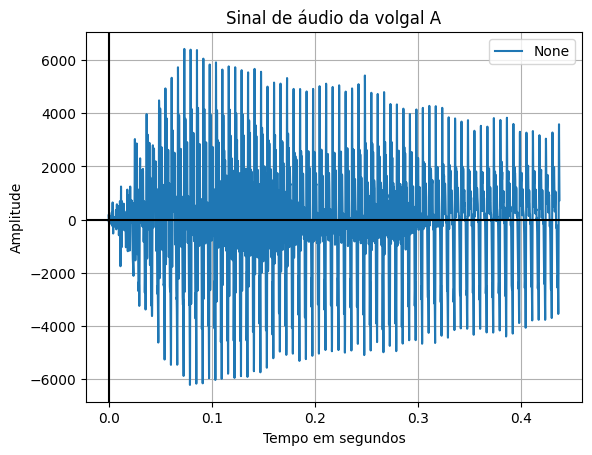

In [308]:
#Vogal A
fs_a, Vg_a = wav.read('2 - Fourier_Vogais_a.wav')
Na, T1a, Ta, Pico_a, Ttot_a = extrai_vogal(fs_a, Vg_a)
plotar_grafico(Ta, Vg_a, 'Sinal de áudio da volgal A')
Audio(Vg_a, rate=fs_a)

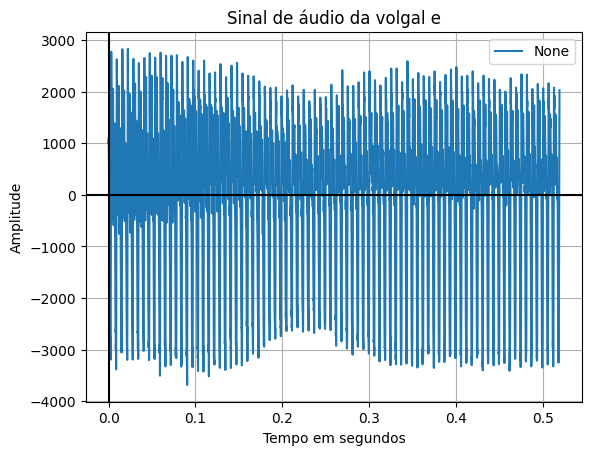

In [309]:
#Vogal E
fs_e, Vg_e = wav.read('2 - Fourier_Vogais_e.wav')
Ne, T1e, Te, Pico_e , Ttot_e = extrai_vogal(fs_e, Vg_e)
plotar_grafico(Te, Vg_e, 'Sinal de áudio da volgal e')
Audio(Vg_e, rate=fs_e)

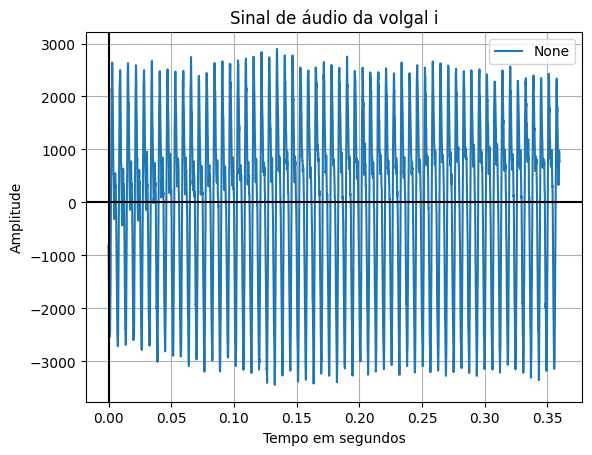

In [310]:
#Vogal I
fs_i, Vg_i = wav.read('2 - Fourier_Vogais_i.wav')
Ni, T1i, Ti, Pico_i, Ttot_i = extrai_vogal(fs_i, Vg_i)
plotar_grafico(Ti, Vg_i, 'Sinal de áudio da volgal i')
Audio(Vg_i, rate=fs_i)

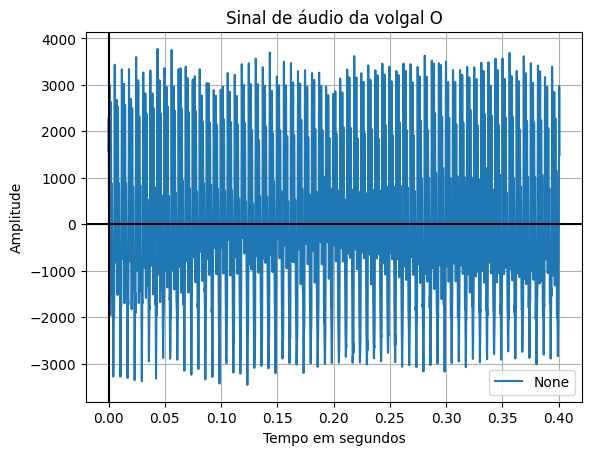

In [311]:
#Vogal O
fs_o, Vg_o = wav.read('2 - Fourier_Vogais_o.wav')
No, T1o, To, Pico_o, Ttot_o = extrai_vogal(fs_o, Vg_o)
plotar_grafico(To, Vg_o, 'Sinal de áudio da volgal O')
Audio(Vg_o, rate=fs_o)

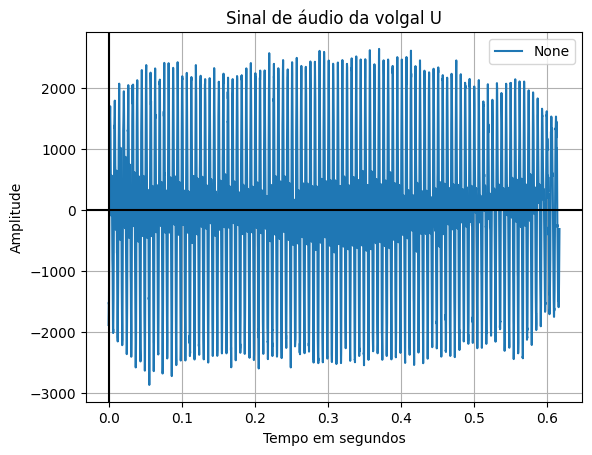

In [341]:
#Vogal U
fs_u, Vg_u = wav.read('2 - Fourier_Vogais_u.wav')
Nu, T1u, Tu, Pico_u, Ttot_u = extrai_vogal(fs_u, Vg_u)
plotar_grafico(Tu, Vg_u, 'Sinal de áudio da volgal U')
Audio(Vg_u, rate=fs_u)

## Ponderando as vogais

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

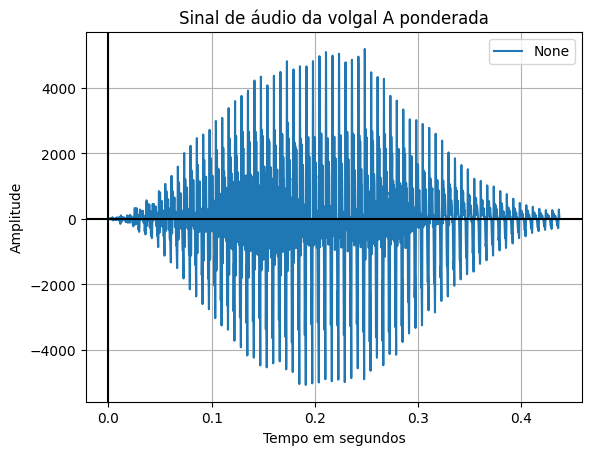

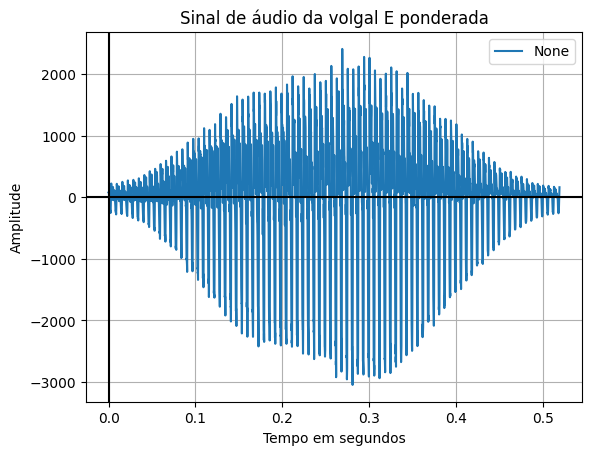

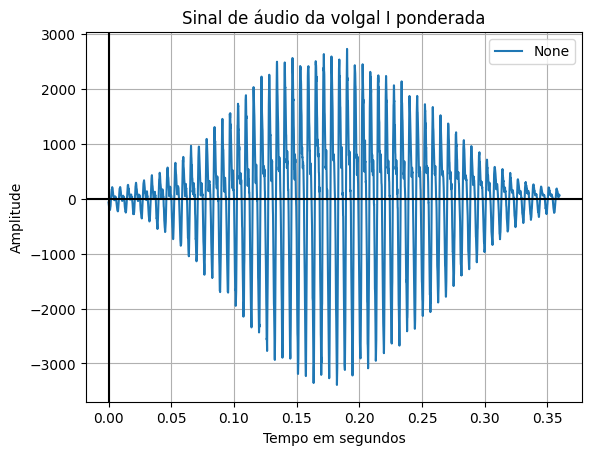

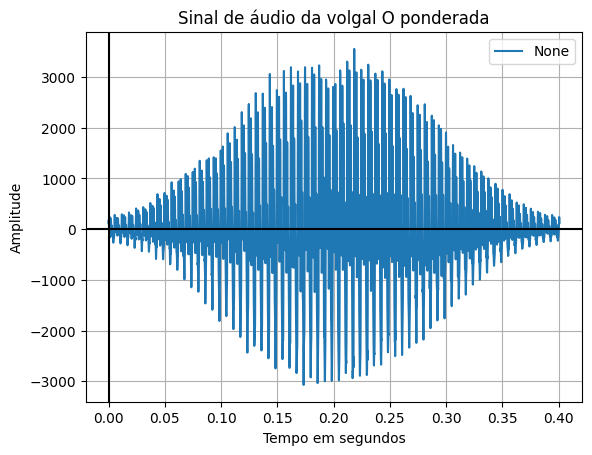

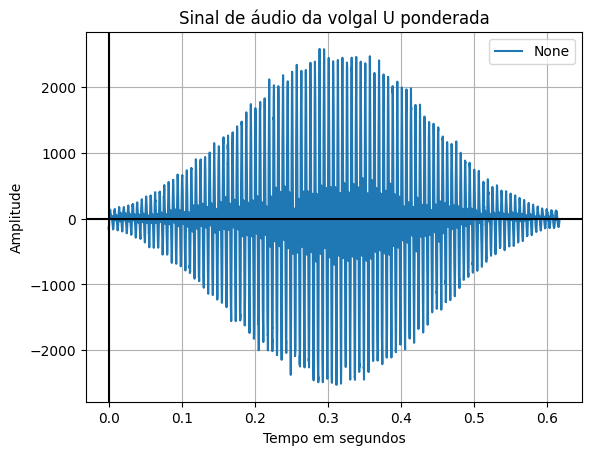

In [340]:
#Vogal A ponderada
Vg_ap = ponderar_vogal(Na, Vg_a)
plotar_grafico(Ta, Vg_ap, 'Sinal de áudio da volgal A ponderada', n_figure=3)

#Vogal E ponderada
Vg_ep = ponderar_vogal(Ne, Vg_e)
plotar_grafico(Te, Vg_ep, 'Sinal de áudio da volgal E ponderada', n_figure=4)

#Vogal I ponderada
Vg_ip = ponderar_vogal(Ni, Vg_i)
plotar_grafico(Ti, Vg_ip, 'Sinal de áudio da volgal I ponderada', n_figure=5)

#Vogal O ponderada
Vg_op = ponderar_vogal(No, Vg_o)
plotar_grafico(To, Vg_op, 'Sinal de áudio da volgal O ponderada', n_figure=6)

#Vogal U ponderada
Vg_up = ponderar_vogal(Nu, Vg_u)
plotar_grafico(Tu, Vg_up, 'Sinal de áudio da volgal U ponderada', n_figure=7)

#  Encontrar a frequência fundamental de cada vogal

## Vogal A

Frequência fundamental da vogal A:159.14Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

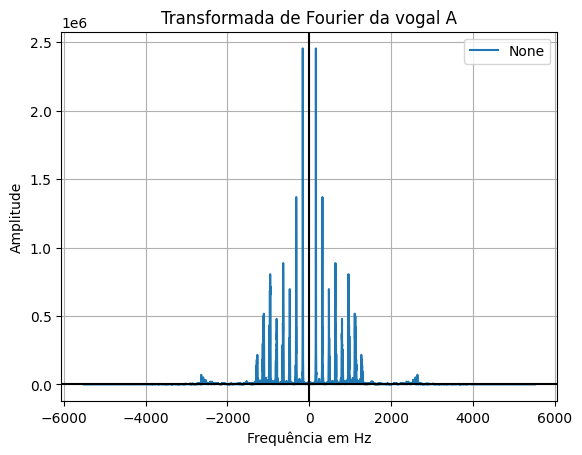

In [314]:
# Vogal A Fourier
Fourier_a, frequencia_a, freq_fund_a, Fourier_a_sem_shift = calcula_fourier(Vg_ap, fs_a)
print(f'Frequência fundamental da vogal A:{freq_fund_a:,.2f}Hz')
plotar_grafico(frequencia_a, Fourier_a, 'Transformada de Fourier da vogal A', label_x='Frequência em Hz')

# Vogal E

Frequência fundamental da vogal E:157.06Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

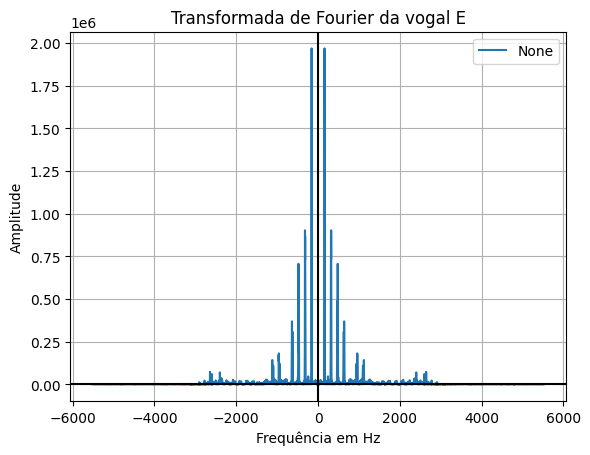

In [315]:
# Vogal E Fourier
Fourier_e, frequencia_e, freq_fund_e, Fourier_e_sem_shift = calcula_fourier(Vg_ep, fs_e)
print(f'Frequência fundamental da vogal E:{freq_fund_e:,.2f}Hz')
plotar_grafico(frequencia_e, Fourier_e, 'Transformada de Fourier da vogal E', label_x='Frequência em Hz')

# Vogal I


Frequência fundamental da vogal I:159.88Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

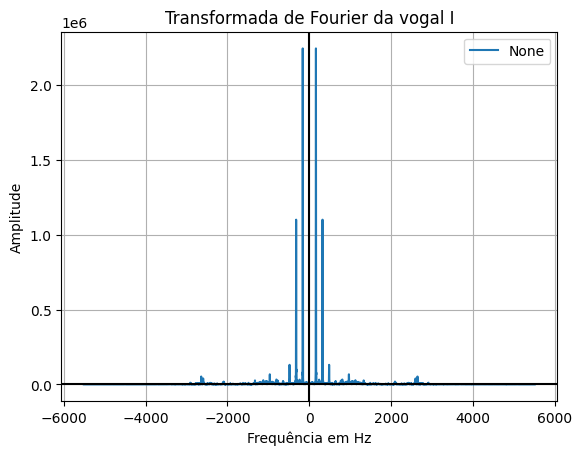

In [339]:
# Vogal I Fourier
Fourier_i, frequencia_i, freq_fund_i, Fourier_i_sem_shift = calcula_fourier(Vg_ip, fs_i)
print(f'Frequência fundamental da vogal I:{freq_fund_i:,.2f}Hz')
plotar_grafico(frequencia_i, Fourier_i, 'Transformada de Fourier da vogal I', label_x='Frequência em Hz')

# Vogal O

Frequência fundamental da vogal O:159.71Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

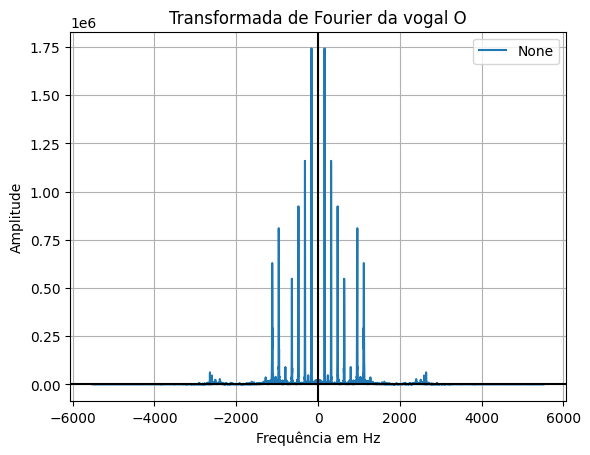

In [317]:
# Vogal O Fourier
Fourier_o, frequencia_o, freq_fund_o, Fourier_o_sem_shift = calcula_fourier(Vg_op, fs_o)
print(f'Frequência fundamental da vogal O:{freq_fund_o:,.2f}Hz')
plotar_grafico(frequencia_o, Fourier_o, 'Transformada de Fourier da vogal O', label_x='Frequência em Hz')

# Vogal U

Frequência fundamental da vogal U:160.56Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

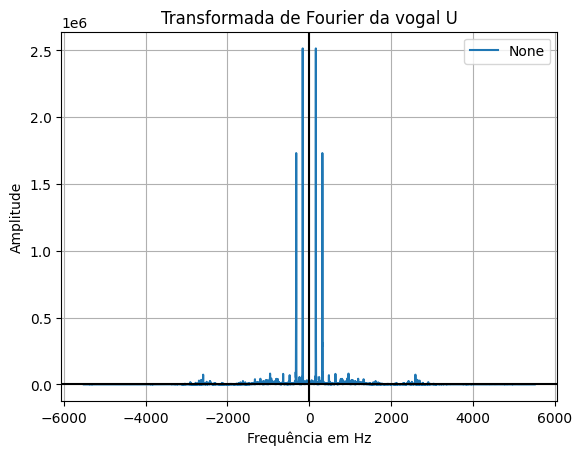

In [318]:
#Vogal U Fourier
Fourier_u, frequencia_u, freq_fund_u, Fourier_u_sem_shift = calcula_fourier(Vg_up, fs_u)
print(f'Frequência fundamental da vogal U:{freq_fund_u:,.2f}Hz')
plotar_grafico(frequencia_u, Fourier_u, 'Transformada de Fourier da vogal U', label_x='Frequência em Hz')

## Encontrando as formantes

### Formante vogal A

Primeira formante da vogal A:161.43Hz
Segunda formante da vogal A:958.25Hz
Terceira formante da vogal A:2,075.63Hz


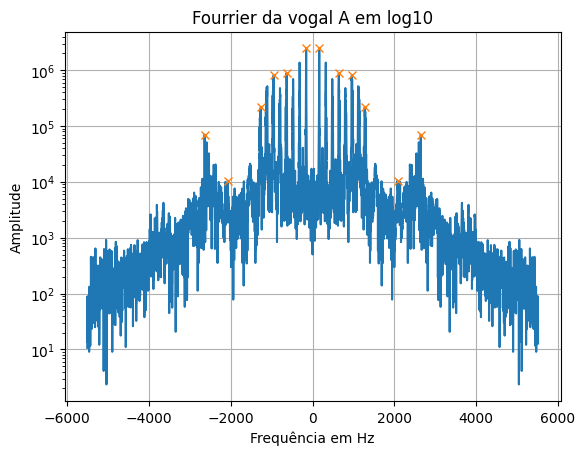

In [346]:
picos_form_a, _ = find_peaks(Fourier_a, height=0, distance=130, prominence=10000)
plt.figure()
plt.plot(frequencia_a, np.abs(Fourier_a))
plt.title('Fourrier da vogal A em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.grid(True, which='major')
plt.plot(frequencia_a[picos_form_a], np.abs(Fourier_a[picos_form_a]), "x")

print(f'Primeira formante da vogal A:{frequencia_a[picos_form_a[6]]:,.2f}Hz')
print(f'Segunda formante da vogal A:{frequencia_a[picos_form_a[8]]:,.2f}Hz')
print(f'Terceira formante da vogal A:{frequencia_a[picos_form_a[10]]:,.2f}Hz')




### Formante vogal E

Primeira formante da vogal E:158.99Hz
Segunda formante da vogal E:958.74Hz
Terceira formante da vogal E:2,643.03Hz


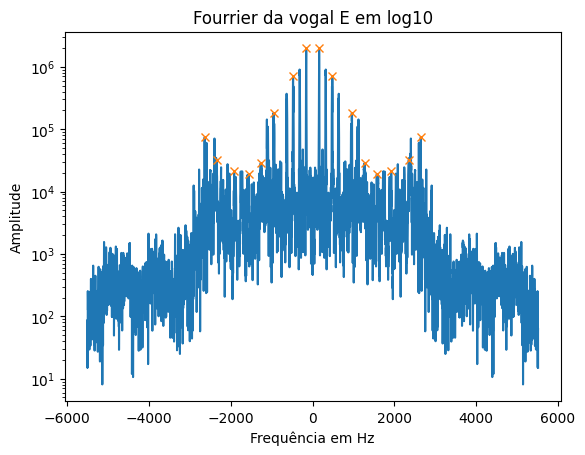

In [320]:
picos_form_e, _ = find_peaks(Fourier_e, height=0, distance=150, prominence=10000)
plt.figure()
plt.plot(frequencia_e, np.abs(Fourier_e))
plt.title('Fourrier da vogal E em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.grid(True, which='major')
plt.plot(frequencia_e[picos_form_e], np.abs(Fourier_e[picos_form_e]), "x")

print(f'Primeira formante da vogal E:{frequencia_e[picos_form_e[8]]:,.2f}Hz')
print(f'Segunda formante da vogal E:{frequencia_e[picos_form_e[10]]:,.2f}Hz')
print(f'Terceira formante da vogal E:{frequencia_e[picos_form_e[15]]:,.2f}Hz')

### Formante Vogal I

Primeira formante da vogal I:162.66Hz
Segunda formante da vogal I:969.03Hz
Terceira formante da vogal I:2,645.72Hz


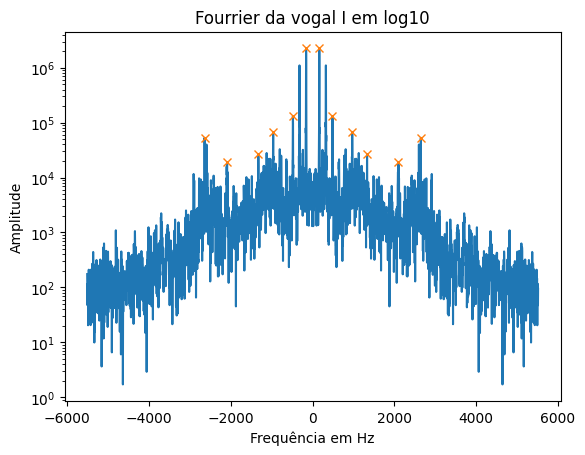

In [321]:
picos_form_i, _ = find_peaks(Fourier_i, height=0, distance=100, prominence=10000)
plt.figure()
plt.plot(frequencia_i, np.abs(Fourier_i))
plt.title('Fourrier da vogal I em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.grid(True, which='major')
plt.plot(frequencia_i[picos_form_i], np.abs(Fourier_i[picos_form_i]), "x")

print(f'Primeira formante da vogal I:{frequencia_i[picos_form_i[6]]:,.2f}Hz')
print(f'Segunda formante da vogal I:{frequencia_i[picos_form_i[8]]:,.2f}Hz')
print(f'Terceira formante da vogal I:{frequencia_i[picos_form_i[11]]:,.2f}Hz')

### Formante Vogal O

Primeira formante da vogal O:159.71Hz
Segunda formante da vogal O:960.76Hz
Terceira formante da vogal O:2,642.71Hz


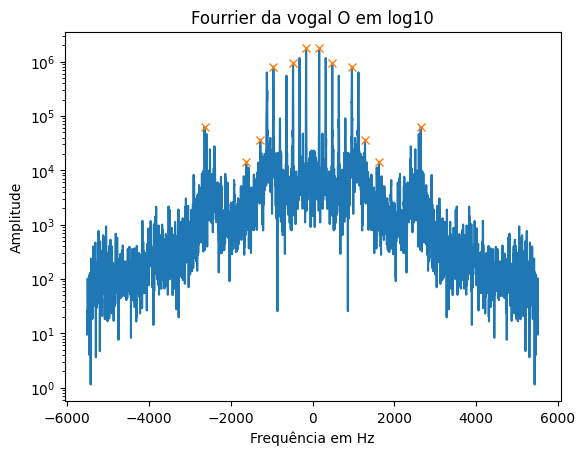

In [322]:
picos_form_o, _ = find_peaks(Fourier_o, height=0, distance=100, prominence=10000)
plt.figure()
plt.plot(frequencia_o, np.abs(Fourier_o))
plt.title('Fourrier da vogal O em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.grid(True, which='major')
plt.plot(frequencia_o[picos_form_o], np.abs(Fourier_o[picos_form_o]), "x")

print(f'Primeira formante da vogal O:{frequencia_o[picos_form_o[6]]:,.2f}Hz')
print(f'Segunda formante da vogal O:{frequencia_o[picos_form_o[8]]:,.2f}Hz')
print(f'Terceira formante da vogal O:{frequencia_o[picos_form_o[11]]:,.2f}Hz')


### Formante Vogal U

Primeira formante da vogal U:160.56Hz
Segunda formante da vogal U:958.48Hz
Terceira formante da vogal U:2,594.88Hz


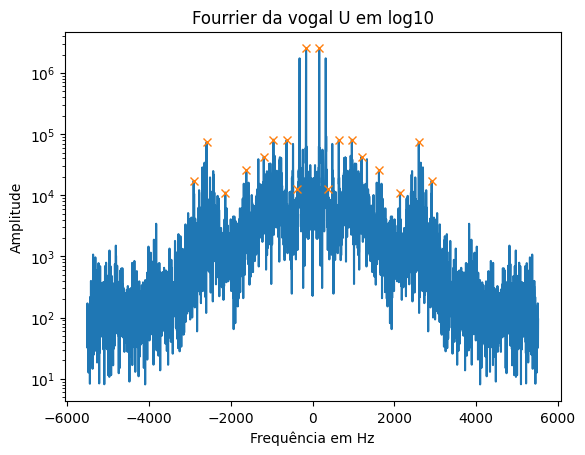

In [323]:
picos_form_u, _ = find_peaks(Fourier_u, height=0, distance=130, prominence=10000)
plt.figure()
plt.plot(frequencia_u, np.abs(Fourier_u))
plt.title('Fourrier da vogal U em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.grid(True, which='major')
plt.plot(frequencia_u[picos_form_u], np.abs(Fourier_u[picos_form_u]), "x")

print(f'Primeira formante da vogal U:{frequencia_u[picos_form_u[9]]:,.2f}Hz')
print(f'Segunda formante da vogal U:{frequencia_u[picos_form_u[12]]:,.2f}Hz')
print(f'Terceira formante da vogal U:{frequencia_u[picos_form_u[16]]:,.2f}Hz')

# Obtendo outras informações das vogais

### Vogai com audio cortado

A partir desse ponto a função plotar_grafico não esta sendo utilizada pois plotando os graficos de fomra individual a visualização fica melhor e ainda não encontrei uma forma de corrigir isso

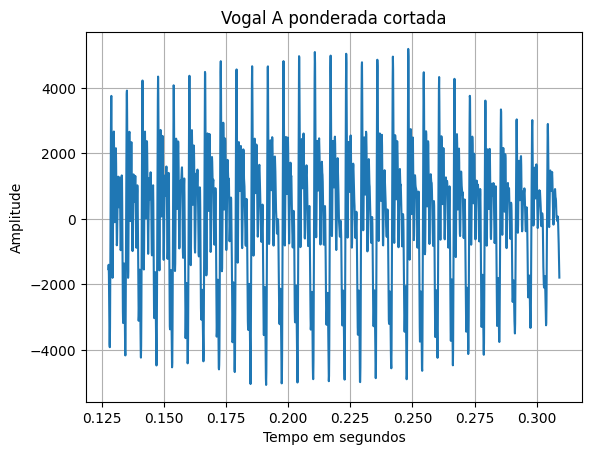

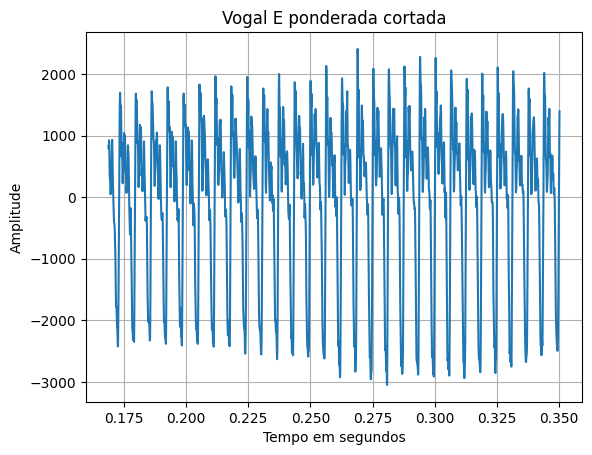

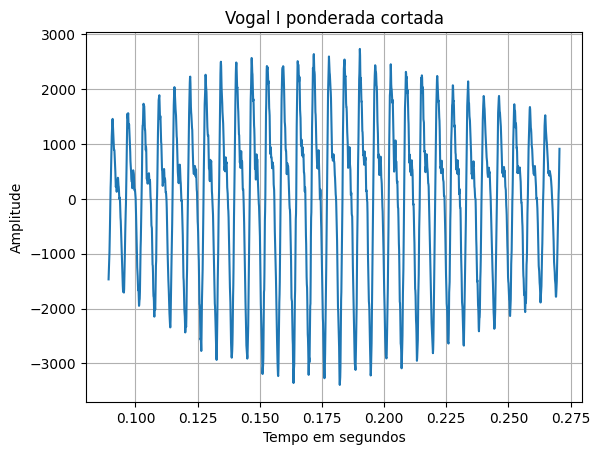

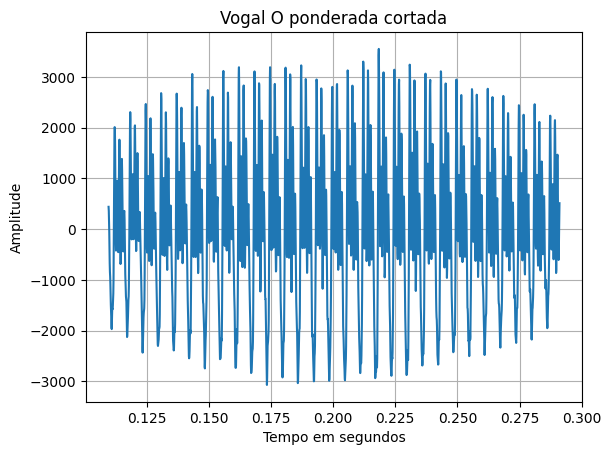

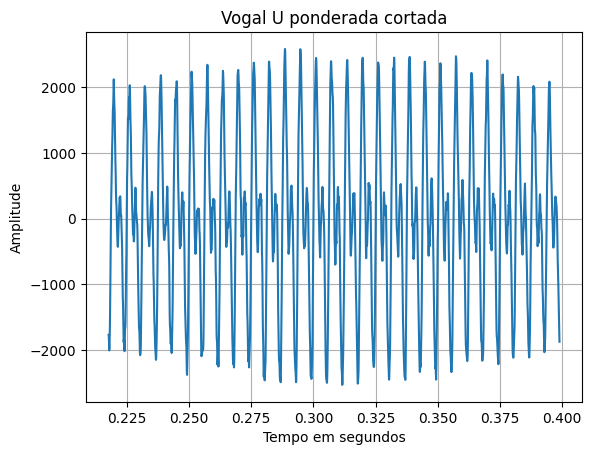

In [347]:
Ta2, Vg_a2 = corta_vogal(Vg_ap, Ta)
plt.figure(8)
plt.plot(Ta2, Vg_a2)
plt.title('Vogal A ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

Te2, Vg_e2 = corta_vogal(Vg_ep, Te)
plt.figure(9)
plt.plot(Te2, Vg_e2)
plt.title('Vogal E ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

Ti2, Vg_i2 = corta_vogal(Vg_ip, Ti)
plt.figure(10)
plt.plot(Ti2, Vg_i2)
plt.title('Vogal I ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

To2, Vg_o2 = corta_vogal(Vg_op, To)
plt.figure(11)
plt.plot(To2, Vg_o2)
plt.title('Vogal O ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

Tu2, Vg_u2 = corta_vogal(Vg_up, Tu)
plt.figure(12)
plt.plot(Tu2, Vg_u2)
plt.title('Vogal U ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

## Achando os picos

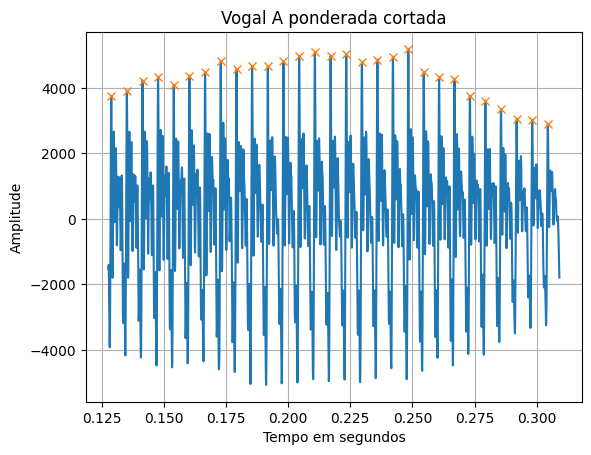

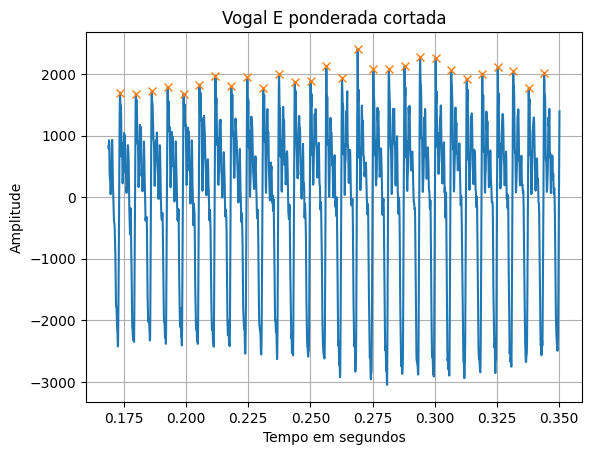

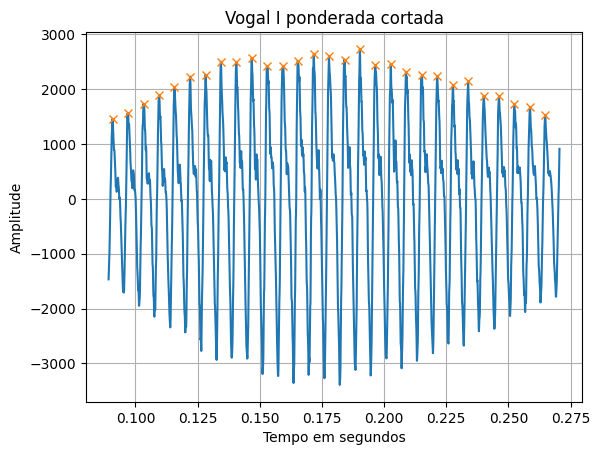

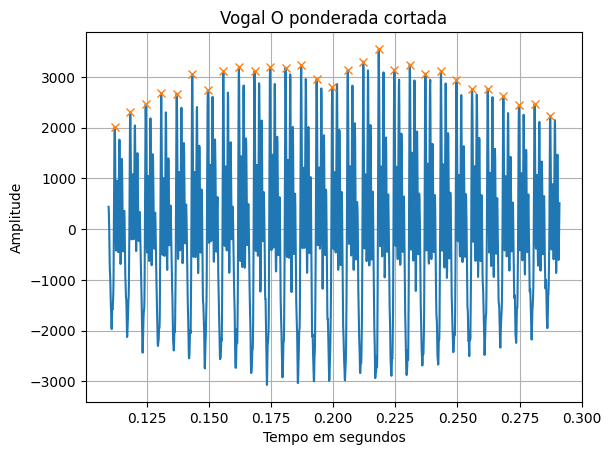

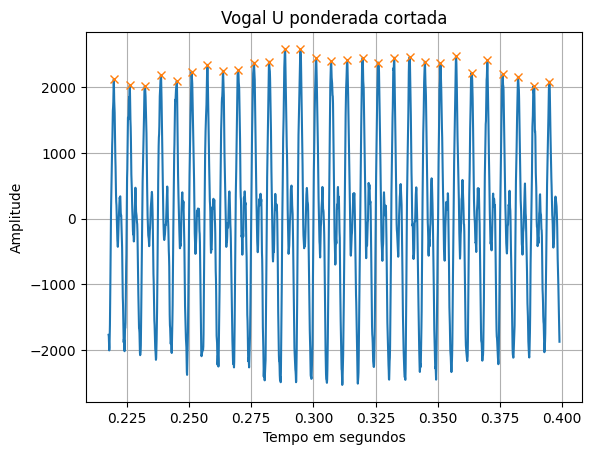

In [348]:
picos_a = picos_vogal(Vg_a2)
plt.figure(13)
plt.plot(Ta2, Vg_a2)
plt.title('Vogal A ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Ta2[picos_a], Vg_a2[picos_a], "x")
plt.grid(True, which='both')

picos_e = picos_vogal(Vg_e2)
plt.figure(14)
plt.plot(Te2, Vg_e2)
plt.title('Vogal E ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Te2[picos_e], Vg_e2[picos_e], "x")
plt.grid(True, which='both')

picos_i = picos_vogal(Vg_i2)
plt.figure(15)
plt.plot(Ti2, Vg_i2)
plt.title('Vogal I ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Ti2[picos_i], Vg_i2[picos_i], "x")
plt.grid(True, which='both')

picos_o = picos_vogal(Vg_o2)
plt.figure(16)
plt.plot(To2, Vg_o2)
plt.title('Vogal O ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(To2[picos_o], Vg_o2[picos_o], "x")
plt.grid(True, which='both')

picos_u = picos_vogal(Vg_u2)
plt.figure(17)
plt.plot(Tu2, Vg_u2)
plt.title('Vogal U ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Tu2[picos_u], Vg_u2[picos_u], "x")
plt.grid(True, which='both')


## Picos em 1 período da vogal

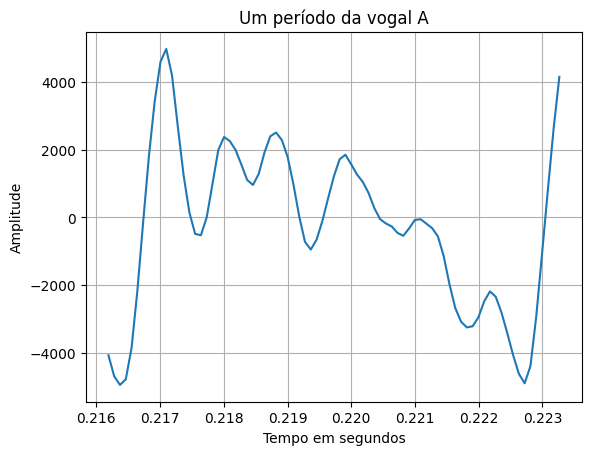

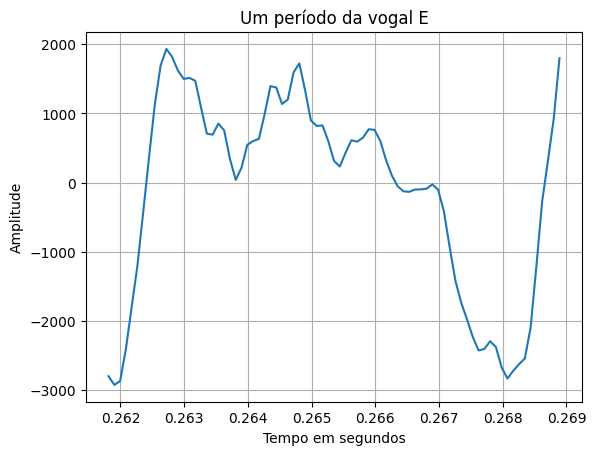

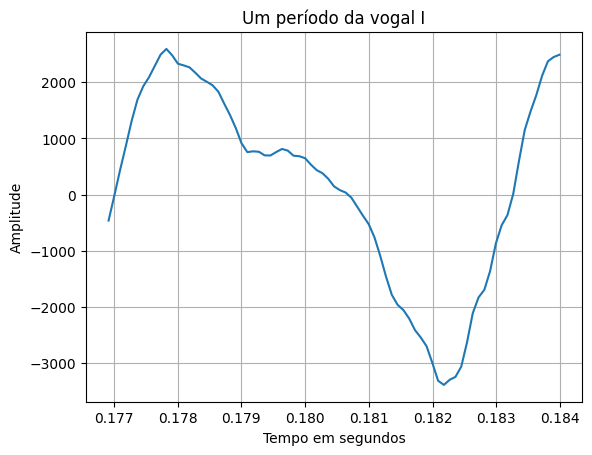

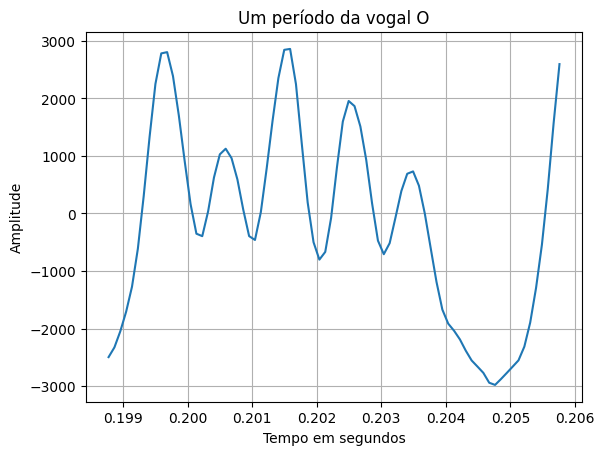

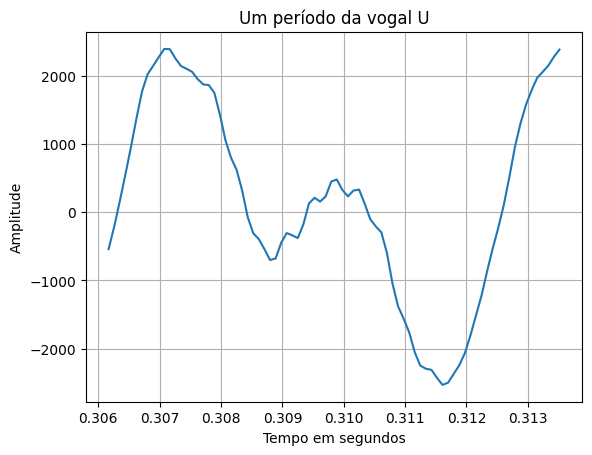

In [349]:
periodo_ta, periodo_a = um_periodo(picos_a, Vg_a2, Ta2)
plt.figure(18)
plt.plot(periodo_ta, periodo_a)
plt.title('Um período da vogal A')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

periodo_te, periodo_e = um_periodo(picos_e, Vg_e2, Te2)
plt.figure(19)
plt.plot(periodo_te, periodo_e)
plt.title('Um período da vogal E')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

periodo_ti, periodo_i = um_periodo(picos_i, Vg_i2, Ti2)
plt.figure(20)
plt.plot(periodo_ti, periodo_i)
plt.title('Um período da vogal I')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

periodo_to, periodo_o = um_periodo(picos_o, Vg_o2, To2)
plt.figure(21)
plt.plot(periodo_to, periodo_o)
plt.title('Um período da vogal O')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')

periodo_tu, periodo_u = um_periodo(picos_u, Vg_u2, Tu2)
plt.figure(22)
plt.plot(periodo_tu, periodo_u)
plt.title('Um período da vogal U')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.grid(True, which='both')


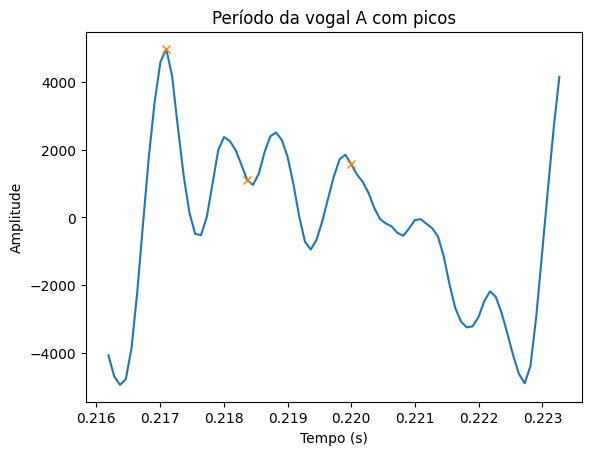

In [327]:
zero_a = picos_periodo(periodo_a, periodo_ta, 'A')

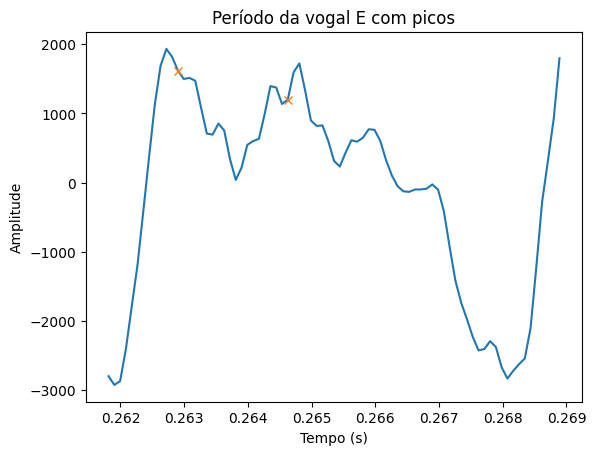

In [328]:
zero_e = picos_periodo(periodo_e, periodo_te, 'E')

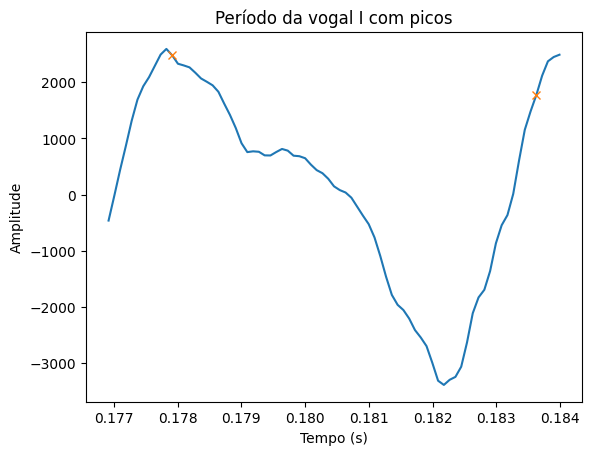

In [329]:
zero_i = picos_periodo(periodo_i, periodo_ti, 'I')

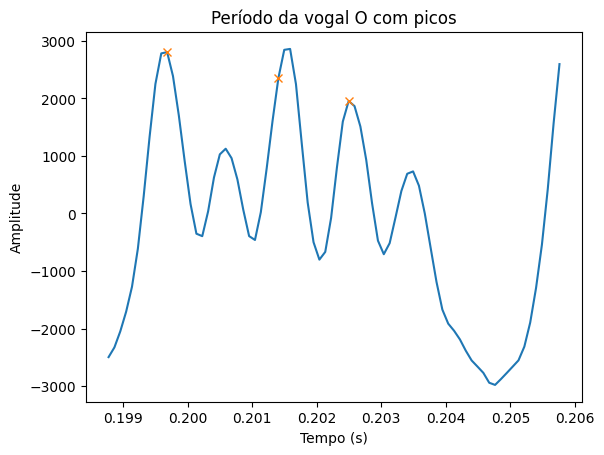

In [330]:
zero_o = picos_periodo(periodo_o, periodo_to, 'O')

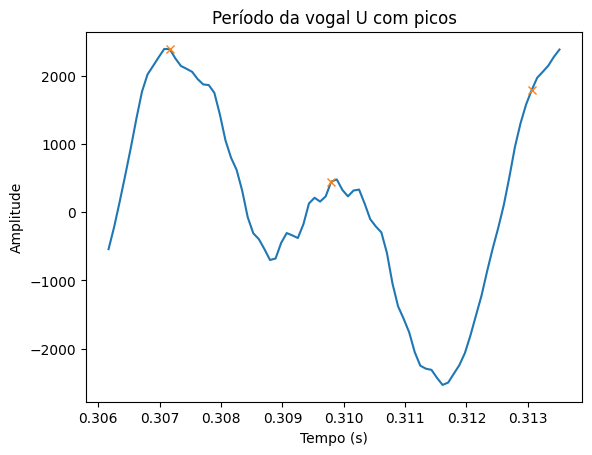

In [331]:
zero_u = picos_periodo(periodo_u, periodo_tu, 'U')

# 3. Encontrar a função de Laplace para um trecho de uma determinada vogal 

### Aproximando os picos por exponencial

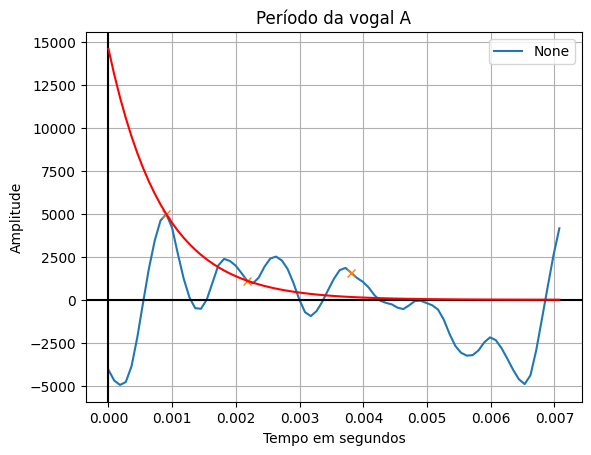

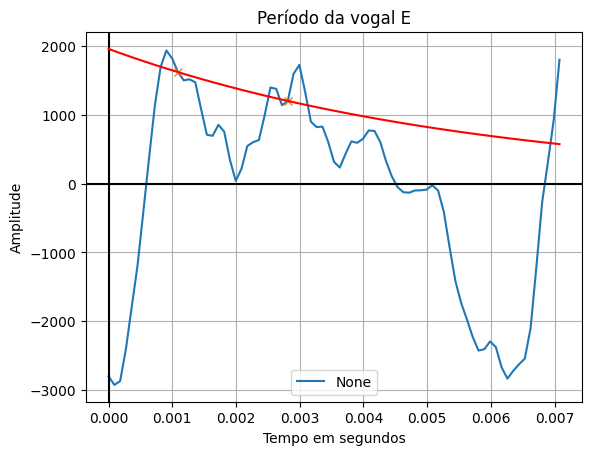

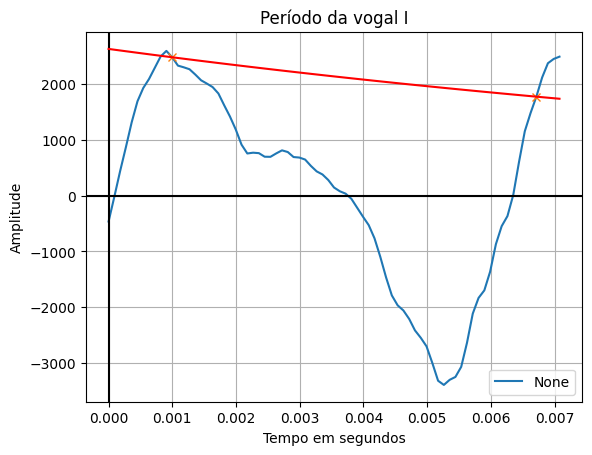

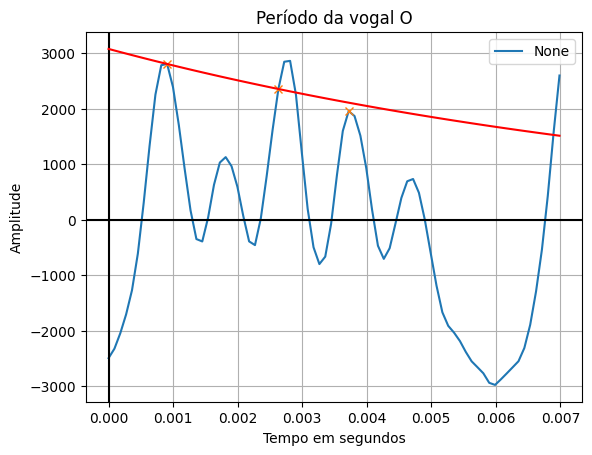

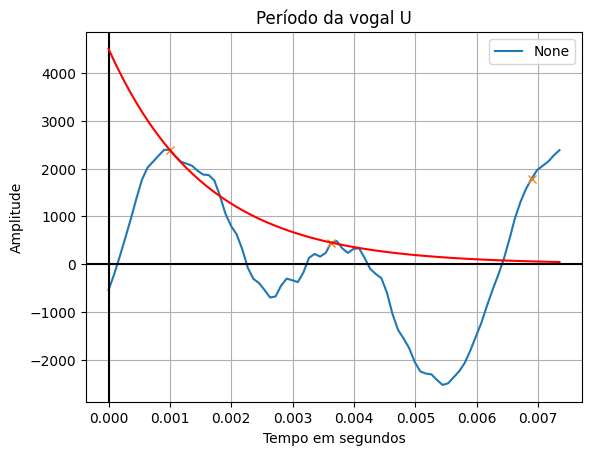

In [332]:
pico_exp_a, periodo_t_0_a = picos_exp(zero_a, periodo_a, periodo_ta)
plot_exp_a = plotar_grafico(periodo_t_0_a, periodo_a, 'Período da vogal A', label_x='Tempo em segundos', label_y='Amplitude', n_figure=23)
plot_exp_a.plot(periodo_t_0_a[zero_a], periodo_a[zero_a], "x")
plot_exp_a.plot(periodo_t_0_a, vexp(periodo_t_0_a, *pico_exp_a), 'r-')

pico_exp_e, periodo_t_0_e = picos_exp(zero_e, periodo_e, periodo_te)
plot_exp_e = plotar_grafico(periodo_t_0_e, periodo_e, 'Período da vogal E', label_x='Tempo em segundos', label_y='Amplitude', n_figure=24)
plot_exp_e.plot(periodo_t_0_e[zero_e], periodo_e[zero_e], "x")
plot_exp_e.plot(periodo_t_0_e, vexp(periodo_t_0_e, *pico_exp_e), 'r-')

pico_exp_i, periodo_t_0_i = picos_exp(zero_i, periodo_i, periodo_ti)
plot_exp_i = plotar_grafico(periodo_t_0_i, periodo_i, 'Período da vogal I', label_x='Tempo em segundos', label_y='Amplitude', n_figure=25)
plot_exp_i.plot(periodo_t_0_i[zero_i], periodo_i[zero_i], "x")
plot_exp_i.plot(periodo_t_0_i, vexp(periodo_t_0_i, *pico_exp_i), 'r-')

pico_exp_o, periodo_t_0_o = picos_exp(zero_o, periodo_o, periodo_to)
plot_exp_o = plotar_grafico(periodo_t_0_o, periodo_o, 'Período da vogal O', label_x='Tempo em segundos', label_y='Amplitude', n_figure=26)
plot_exp_o.plot(periodo_t_0_o[zero_o], periodo_o[zero_o], "x")
plot_exp_o.plot(periodo_t_0_o, vexp(periodo_t_0_o, *pico_exp_o), 'r-')

pico_exp_u, periodo_t_0_u = picos_exp(zero_u, periodo_u, periodo_tu)
plot_exp_u = plotar_grafico(periodo_t_0_u, periodo_u, 'Período da vogal U', label_x='Tempo em segundos', label_y='Amplitude', n_figure=27)
plot_exp_u.plot(periodo_t_0_u[zero_u], periodo_u[zero_u], "x")
plot_exp_u.plot(periodo_t_0_u, vexp(periodo_t_0_u, *pico_exp_u), 'r-')


### W da vogal

In [333]:
w_a = calcula_w(periodo_t_0_a, zero_a)
print(f'Ômega vogal A:{w_a}')

w_e = calcula_w(periodo_t_0_e, zero_e)
print(f'Ômega vogal E:{w_e}')

w_i = calcula_w(periodo_t_0_i, zero_i)
print(f'Ômega vogal I:{w_i}')

w_o = calcula_w(periodo_t_0_o, zero_o)
print(f'Ômega vogal O:{w_o}')

w_u = calcula_w(periodo_t_0_u, zero_u)
print(f'Ômega vogal U:{w_u}')


Ômega vogal A:4328.608391638811
Ômega vogal E:3645.2637754988164
Ômega vogal I:1099.280182808683
Ômega vogal O:4468.157550978421
Ômega vogal U:2131.1362903740437


### Definindo os parametros para a função de laplace

In [334]:
# la_place = {
#         'a': pico_exp[0],
#         'b': pico_exp[1],
#         'f': f_periodo,
#         'vowel_synth': vowel_synth,
#         'period': period,
#         'period_t_from_zero': period_t_from_zero,
#         }

In [335]:
la_place_a = {
    'a': pico_exp_a[0],
    'b': pico_exp_a[1],
    'f': T1a
}
func_la_place_a = calcula_la_place(la_place_a)
print(f'Função de transferência vogal A:{func_la_place_a}')

la_place_e = {
    'a': pico_exp_e[0],
    'b': pico_exp_e[1],
    'f': T1e
}
func_la_place_e = calcula_la_place(la_place_e)
print(f'Função de transferência vogal E:{func_la_place_e}')

la_place_i = {
    'a': pico_exp_i[0],
    'b': pico_exp_i[1],
    'f': T1i
}
func_la_place_i = calcula_la_place(la_place_i)
print(f'Função de transferência vogal I:{func_la_place_i}')

la_place_o = {
    'a': pico_exp_o[0],
    'b': pico_exp_o[1],
    'f': T1o
}
func_la_place_o = calcula_la_place(la_place_o)
print(f'Função de transferência vogal O:{func_la_place_o}')

la_place_u = {
    'a': pico_exp_u[0],
    'b': pico_exp_u[1],
    'f': T1u
}
func_la_place_u = calcula_la_place(la_place_u)
print(f'Função de transferência vogal U:{func_la_place_u}')

Função de transferência vogal A:
         8.319
------------------------
s^2 + 2368 s + 1.402e+06

Função de transferência vogal E:
         1.114
-----------------------
s^2 + 347 s + 3.016e+04

Função de transferência vogal I:
      1.499
------------------
s^2 + 117 s + 3435

Função de transferência vogal O:
         1.753
-----------------------
s^2 + 203 s + 1.034e+04

Função de transferência vogal U:
         2.567
------------------------
s^2 + 1270 s + 4.037e+05



## Sintetizando a vogal

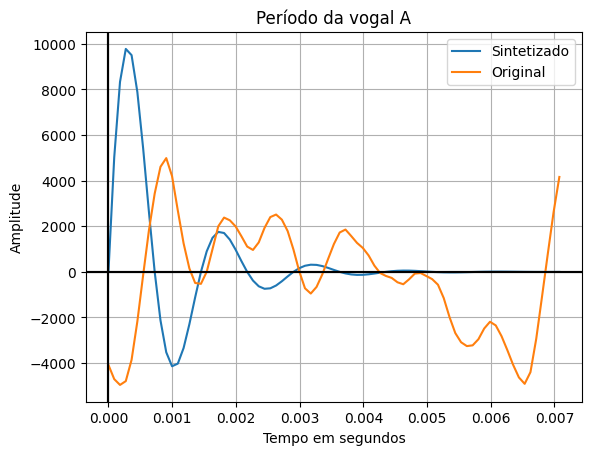

In [338]:
a_sintetizado = sintetiza_vogal(w_a, pico_exp_a, periodo_t_0_a)
plotar_grafico(periodo_t_0_a, a_sintetizado, 'Período da vogal A sintetizado', label_x='Tempo em segundos', label_y='Amplitude', n_figure=28, labelg='Sintetizado')
plotar_grafico(periodo_t_0_a, periodo_a, 'Período da vogal A', label_x='Tempo em segundos', label_y='Amplitude', n_figure=28, labelg='Original')

e_sintetizado = sintetiza_vogal(w_e, pico_exp_e, periodo_t_0_e)
